In [1]:
import cv2
import mediapipe as mp
import numpy as np
import time
import pygame
from tkinter import messagebox
import pyautogui as pg
import csv
import matplotlib.pyplot as plt
import json
import os

pygame.mixer.init()
pygame.mixer.music.load("asset/bicycle-bell.mp3")
pygame.mixer.music.set_volume(1.0)

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

angles=[]
time_points = []


def calculate_angle(a,b):
    a = np.array(a)
    b = np.array(b)
    radians = np.arctan2(b[1]-a[1], b[0]-a[0])
    angle = np.abs(radians*180.0/np.pi)
    
    return angle 

def save_user_data(name, angles, average_angle, alert_times, sitting_duration, elapsed_time):
    data = {
        "User": name,
        "Alert Times": alert_times,
        "Sitting Duration": f"{sitting_duration} seconds",
        "Average Angle": average_angle,
        "Elapsed Time": f"{elapsed_time // 60} minutes {elapsed_time % 60} seconds"
    }
    with open(f"{name}_data.json", "a") as json_file:
        json.dump(data, json_file, indent=2)

    plt.figure(figsize=(9, 7))
    plt.plot(time_points, angles)
    plt.xlabel('Time')
    plt.ylabel('Angle')

    plt.title('Posture Analysis\n\n', fontsize=14)
    plt.title(f'\nElapsed Time: {elapsed_time // 60}m {elapsed_time % 60}s \nAverage Angle: {average_angle:.2f} degrees', fontsize=9, loc='left')

    plt.ylim(140, 180)
    threshold = 165
    below_threshold = [(time, angle) for time, angle in zip(time_points, angles) if angle <= threshold]
    times, below_threshold_angles = zip(*below_threshold)
    plt.scatter(times, below_threshold_angles, color='red', marker='o')

    plt.legend()
    plt.savefig(f"{name}_posture_angles_graph.jpg")
    
    plt.show()

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


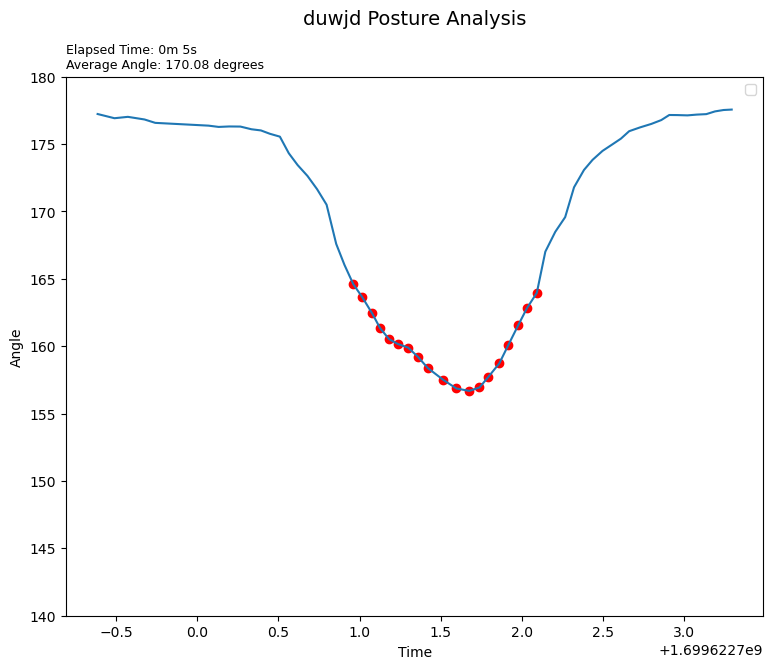

In [2]:

name = pg.prompt(text='What your name?', title='Posture Analysis')
if name is not None:
    cap = cv2.VideoCapture(0)
    
    warning = False
    count = 0
    start = time.gmtime(time.time())
    time_list = []
    

    videos = [
        {"name": "Stretching to relieve shoulder stiffness", "path": "asset/stretching.mp4"},
        {"name": "5 minute morning stretch", "path": "asset/stretching2.mp4"},
        {"name": "8 minutes of deep sleep stretching before going to bed", "path": "asset/stretching3.mp4"},
        {"name": "Sitting full body stretching", "path": "asset/stretching4.mp4"},
        {"name": "Stretching to make your body flexible", "path": "asset/stretching5.mp4"},
        {"name": "Stretching to relieve shoulder stiffness", "path": "asset/stretching.mp4"},
        {"name": "5 minute morning stretch", "path": "asset/stretching2.mp4"},
        {"name": "8 minutes of deep sleep stretching before going to bed", "path": "asset/stretching3.mp4"},
        {"name": "Sitting full body stretching", "path": "asset/stretching4.mp4"}
    ]

    # Stretching 버튼을 클릭했을 때 호출되는 함수
    def show_video_list():
        selected_video = -1
        while True:
            # 비디오 목록 화면 생성
            video_list_frame = np.ones((450, 600, 3), dtype=np.uint8) * 105
            cv2.putText(video_list_frame, 'Select a Stretching Video', (100, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(video_list_frame, 'Using keyboard number keys', (190, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (208, 206, 206), 1)
            cv2.rectangle(video_list_frame, (20, 120), (580, 430), (255,255,255), -1)
            y_offset = 155

            for i, video in enumerate(videos):
                cv2.putText(video_list_frame, f'{i + 1}. {video["name"]}', (40, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (113,108,105), 1, cv2.LINE_AA)
                y_offset += 30   
            cv2.imshow('Video List', video_list_frame)

            key = cv2.waitKey(10)
            if key >= ord('1') and key <= ord('9'):
                selected_video = int(chr(key)) - 1
                break
            elif key == ord('q'):
                break  # 'q'를 누르면 Video List 창 닫기
        cv2.destroyWindow("Video List")

        if selected_video != -1:
            # 선택한 비디오 재생
            cap_stretching = cv2.VideoCapture(videos[selected_video]["path"])

            if cap_stretching.isOpened():
                    cv2.namedWindow("Stretching Screen", cv2.WINDOW_NORMAL)
                    cv2.resizeWindow("Stretching Screen", 800, 600)
                    cv2.moveWindow("Stretching Screen", 100, 100)  # 원하는 위치로 창 이동

            while cap_stretching.isOpened():
                ret, frame = cap_stretching.read()

                if not ret:
                    break

                cv2.rectangle(frame, (1150, 630), (1230, 680), (203,195,115), -1)
                cv2.putText(frame, 'Exit', (1170, 660), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.imshow("Stretching Screen", frame)

                if cv2.waitKey(1) & 0xFF == ord('w'):
                    break

                def ok_button_callback(event, x, y, flags, param):
                    if event == cv2.EVENT_LBUTTONDOWN:
                        if 1150 <= x <= 1230 and 630 <= y <= 680:  # OK 버튼 위치
                            cv2.destroyWindow('Stretching Screen')
                            cv2.destroyWindow("Video List")

                cv2.setMouseCallback('Stretching Screen', ok_button_callback)
            cap_stretching.release()


    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            if 800 <= x <= 910 and 650 <= y <= 690:
                # 새 창을 생성하고 하얀 배경으로 초기화
                new_window = np.ones((480, 400, 3), dtype=np.uint8) * 105
                cv2.putText(new_window, 'Your posture analysis', (25, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
                cv2.rectangle(new_window, (20, 90), (380, 400), (255,255,255), -1)
                y_offset = 130  # 출력 위치의 y 오프셋

                for i, time_entry in enumerate(time_list):
                    cv2.putText(new_window, f'Time {i+1} : {time_entry}', 
                                (50, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (113,108,105), 1, cv2.LINE_AA)
                    y_offset += 30

                cv2.rectangle(new_window, (170, 420), (230, 450), (203,195,115), -1)  # OK 버튼 생성
                cv2.putText(new_window, 'OK', (190, 440), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                cv2.imshow('Finish Screen', new_window)

                def ok_button_callback(event, x, y, flags, param):
                    if event == cv2.EVENT_LBUTTONDOWN:
                        if 170 <= x <= 230 and 420 <= y <= 450:  # OK 버튼 위치
                            cv2.destroyWindow('Finish Screen')

                cv2.setMouseCallback('Finish Screen', ok_button_callback)

            elif 800 <= x <= 910 and 600 <= y <= 640:
                show_video_list()


    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            resize_frame = cv2.resize(frame ,None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR) 
            
            image = cv2.cvtColor(resize_frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
        
            # Make detection
            results = pose.process(image)
        
            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            
            try:
                landmarks = results.pose_landmarks.landmark
                
                left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
            
                angle = calculate_angle(left_shoulder, right_shoulder)
                angles.append(angle)
                time_points.append(time.time())
                
                if angle < 170:
                    count = count + 1
                    current_time = time.localtime(time.time())
                    time_entry = f'{current_time.tm_hour:02d}:{current_time.tm_min:02d}'
                    if time_entry not in time_list:
                        time_list.append(time_entry)
                else:
                    count = 0
        
            except:
                pass
            
            now = time.gmtime(time.time())
            cv2.putText(image, 'Running for', 
                        (780,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
            elapsed_time = now.tm_min * 60 + now.tm_sec - (start.tm_min * 60 + start.tm_sec)
            minutes = elapsed_time // 60
            seconds = elapsed_time % 60
            cv2.putText(image, f'{minutes:02d}:{seconds:02d}', 
                        (885,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

            cv2.putText(image, 'POSTURE ANALYSIS', 
                        (355,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            cv2.putText(image, f'{name}', 
                        (30,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
            cv2.putText(image, 'Exit : q', (20, 705), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100,100,100), 1)
            cv2.rectangle(image, (800, 650), (910, 690), (203,195,115), -1)  # OK 버튼 생성
            cv2.putText(image, 'Record', (830, 675), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            
            cv2.rectangle(image, (800, 600), (910, 640), (203,195,115), -1)  # OK 버튼 생성
            cv2.putText(image, 'Stretching', (815, 625), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            
            #5분마다 스트레칭 하라고 알림
            if minutes >= 3 and seconds < 10 and minutes % 3 == 0:
                cv2.putText(image, 'You sit for a long time.', 
                        (230,400), cv2.FONT_HERSHEY_SIMPLEX, 1, (203,195,203), 1, cv2.LINE_AA)
                cv2.putText(image, 'Please do some stretching.', 
                        (220,450), cv2.FONT_HERSHEY_SIMPLEX, 1, (203,195,203), 2, cv2.LINE_AA)
            
            #자세 안좋으면 경고창             
            if count > 10:
                pygame.mixer.music.play()
                new_window = np.ones((150, 450, 3), dtype=np.uint8) * 135
                cv2.putText(new_window, 'Your posture is incorrect', (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
                cv2.rectangle(new_window, (100, 90), (340, 120), (203,195,115), -1)
                cv2.putText(new_window, 'OK, I will be careful', (150, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                cv2.imshow('Clicked Point', new_window)

                def ok_button_callback(event, x, y, flags, param):
                    if event == cv2.EVENT_LBUTTONDOWN:
                        if 190 <= x <= 250 and 90 <= y <= 120:  # OK 버튼 위치
                            cv2.destroyWindow('Clicked Point')

                cv2.setMouseCallback('Clicked Point', ok_button_callback)
            
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                    mp_drawing.DrawingSpec(color=(230,224,192), thickness=2, circle_radius=2), 
                                    mp_drawing.DrawingSpec(color=(153,138,61), thickness=2, circle_radius=2) 
                                    )
            
            cv2.imshow('Main Screen', image)

            cv2.setMouseCallback('Main Screen', mouse_callback)
            
            average_angle = np.mean(angles)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                user_choice = messagebox.askokcancel("Posture Analysis", "Are you sure you want to end the analysis?")
                if user_choice:
                    save_user_data(name, angles, average_angle, time_list, elapsed_time, elapsed_time)

                    break

        cap.release()
        cv2.destroyAllWindows()